In [5]:
# a classification label, with possible values including 'sadness', 'joy', 'love', 'anger', 'fear', 'surprise'

In [35]:
import pandas as pd
import numpy as np
import io

df = pd.read_csv('/content/training.csv')
df = df.dropna()
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [36]:
df.label.unique()

array([0, 3, 2, 5, 4, 1])

<AxesSubplot:>

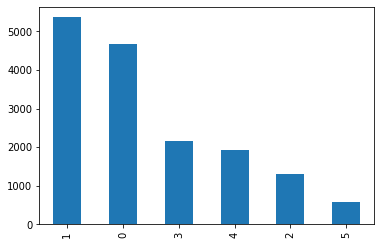

In [37]:
import matplotlib.pyplot as plt
df['label'].value_counts().plot(kind='bar')


In [9]:
import nltk
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [38]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def clean(text):
        text = text.lower() # convert to lowercase
        text = re.sub(r'[^\w\s#]','' , text) # drop all non word and whitespace characters, except for the hashtag
        text = re.sub(r'\d+', 'NUM', text) # replace all digits with NUM
        text = ' '.join([word for word in text.split() if word not in stopwords.words("english")]) # remove stopwords
        return text

df['proc_text'] = df['text'].apply(clean)
df.head()

,text,label,proc_text
0,i didnt feel humiliated,0,didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,0,go feeling hopeless damned hopeful around some...
2,im grabbing a minute to post i feel greedy wrong,3,im grabbing minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,2,ever feeling nostalgic fireplace know still pr...
4,i am feeling grouchy,3,feeling grouchy


In [39]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
encoded_texts = tokenizer(df['proc_text'].values.tolist(), padding=True, truncation=True, return_tensors='tf')
word_index = tokenizer.get_vocab()

In [40]:
len(word_index)

30522

In [43]:
df2 = pd.read_csv('/content/validation.csv')
df2 = df2.dropna()
df2.head()

,text,label
0,im feeling quite sad and sorry for myself but ...,0
1,i feel like i am still looking at a blank canv...,0
2,i feel like a faithful servant,2
3,i am just feeling cranky and blue,3
4,i can have for a treat or if i am feeling festive,1


In [87]:
new_words = set()
for row in df2.itertuples():
    for word in row.text.split():
        if word not in tokenizer.get_vocab():
            new_words.add(word)

tokenizer.add_tokens(list(new_words))

df2['input_ids'] = df2['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

In [116]:
tokenizer.save_pretrained('/content/')

('/content/tokenizer_config.json',
 '/content/special_tokens_map.json',
 '/content/vocab.txt',
 '/content/added_tokens.json',
 '/content/tokenizer.json')

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df['proc_text'].values)
vectors

<15984x15036 sparse matrix of type '<class 'numpy.float64'>'
	with 144621 stored elements in Compressed Sparse Row format>

In [114]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df['proc_text'].values)

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [96]:
targets = df['label'].values
targets

array([0, 0, 3, ..., 1, 3, 0])

In [98]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(vectors, targets, test_size=0.2, random_state=42)

In [88]:
word_index = tokenizer.get_vocab()
len(word_index)

31436

In [107]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

xgb = XGBClassifier()

param_grid = {
    'max_depth': [5, 6, 7],
    'learning_rate': np.arange(0.2, 0.5, 0.05),
    'n_estimators': np.arange(100, 400, 50)
}

random_search = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=5, cv=2)
random_search.fit(x_train, y_train)

print(f'Best parameters: {random_search.best_params_}')
print(f'Best score: {random_search.best_score_:.3f}')

Best parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.39999999999999997}
Best score: 0.881


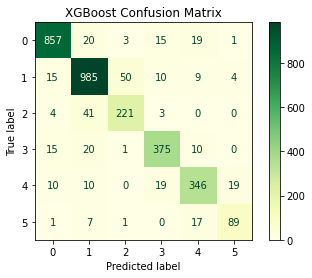

In [109]:
model = XGBClassifier(**random_search.best_params_)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = ConfusionMatrixDisplay(confusion_matrix(y_test, model.predict(x_test)))
cm.plot(cmap = 'YlGn')
plt.title('XGBoost Confusion Matrix')
plt.show()


In [110]:
from sklearn.metrics import classification_report
print(classification_report(y_test, model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       915
           1       0.91      0.92      0.91      1073
           2       0.80      0.82      0.81       269
           3       0.89      0.89      0.89       421
           4       0.86      0.86      0.86       404
           5       0.79      0.77      0.78       115

    accuracy                           0.90      3197
   macro avg       0.87      0.87      0.87      3197
weighted avg       0.90      0.90      0.90      3197



In [112]:
!pip show xgboost

Name: xgboost
Version: 0.90
Summary: XGBoost Python Package
Home-page: https://github.com/dmlc/xgboost
Author: 
Author-email: 
License: Apache-2.0
Location: /usr/local/lib/python3.8/dist-packages
Requires: numpy, scipy
Required-by: 


In [111]:
import pickle

with open('sentiment_model.pkl', 'wb') as file:
    pickle.dump(random_search.best_estimator_, file)